In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sympy import symbols, Eq, solve
from scipy.ndimage.interpolation import shift

In [2]:
# Parameters
t = np.linspace(0,50,51)
D0 = 100
gamma = 0.1
sigma_eps = 3 #cash-flow shocks σε
T = 50
Q = 1
I = 50
X1 = 0.9 #p.207 footnote9
theta = 0.9
mu0 = 0.3 #fraction of fundamental invesetors
mu = [mu0] + [(1-mu0)/I]*I #list of fraction of investors
_w = 0.1
w = [[1] + [np.random.normal(_w, 0.03) for _ in range(I)]\
 for i in range(T)]

In [102]:
np.min(w)

0.0030090995075349736

In [70]:
# Create Dt
e_D = [0]*11 + [2,6,12,18] + [18]*36
Dt = [i + D0 for i in e_D]
Dt = np.array(Dt)

In [74]:
fund_val = Dt - gamma*sigma_eps**2*(T-t)*Q

In [9]:
def binding_p(w_it, _x, _t, _Dt): #binding p for i at t
    return _Dt- gamma*sigma_eps**2*(T-_t-1)*Q + ((1-w_it)*_x/w_it)
def signal_x(lag_x, lag_p, lag2_p):
    return theta*lag_x + (1-theta)*(lag_p-lag2_p)
def demand_f(_Dt, _t, p):
    return (_Dt - gamma*sigma_eps**2*(T-_t-1)*Q - p)/(gamma*sigma_eps**2)
def demand_e(w_it, _Dt, _t, p, _x): #demand of i at t
    return w_it*(_Dt - gamma*sigma_eps**2*(T-_t-1)*Q \
                 - p)/(gamma*sigma_eps**2) + (1-w_it)*(_x/(gamma*sigma_eps**2))

In [138]:
def p_and_demands(_t, _x):
    bp_list = [binding_p(w_i, _x, _t, Dt[_t-1]) for w_i in w[_t-1]]
    bp_star = None
    min_diff = 10000
    N_list = []
    for bp in bp_list:
        demands = [demand_e(w_i, Dt[_t-1], _t, bp, _x) for w_i in w[_t-1]]
        N_bp = np.dot(mu, demands)#np.sum(demands)
        if N_bp > Q and min_diff > N_bp - Q:
            min_diff = N_bp - Q
            bp_star = bp
        N_list.append(N_bp)
    if bp_star != None:
        demands = [demand_e(w_i, Dt[_t-1], _t, bp_star, _x) for w_i in w[_t-1]]
        index = np.where(np.array(demands) > 0)[0]
        temp = np.dot(np.array(mu)[index], 1-np.array(w[_t-1])[index])
        temp1 = np.dot(np.array(mu)[index], np.array(w[_t-1])[index])
        p = Dt[_t-1] + (temp*_x)/(temp1) - gamma\
        *sigma_eps**2*Q*((temp1)*(T-_t-1)+1)/(temp1)
        demands = [np.max([demand_e(w_i, Dt[_t-1], _t, p, _x), 0]) for w_i in w[_t-1]]
    else:
        temp = np.dot(np.array(mu[1:]), 1-np.array(w[_t-1][1:]))
        temp1 = np.dot(np.array(mu[1:]), np.array(w[_t-1][1:]))
        p = Dt[_t-1] + (temp*_x)/(mu0 + temp1) - gamma\
        *sigma_eps**2*Q*((mu0 + temp1)*(T-_t-1)+1)/(mu0 + temp1)
        demands = [demand_e(w_i, Dt[_t-1], _t, p, _x) for w_i in w[_t-1]]

    return p, demands

In [144]:
#generate price, growth signal and demand 

p_list = [55] #start from p0
x_list = [0.9] #start from x1
d_list = []
for _t in t[1:]:
    #print(_t)
    p_list.append(p_and_demands(int(_t), x_list[-1])[0])
    d_list.append(p_and_demands(int(_t), x_list[-1])[1])
    x_list.append(signal_x(x_list[-1], p_list[-1], p_list[-2]))

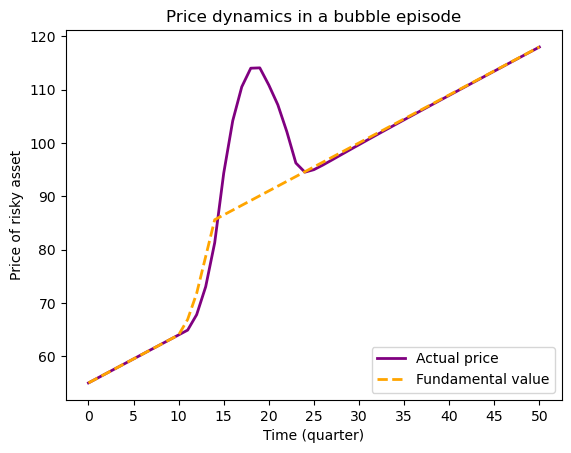

In [140]:
#price
plt.plot(t, p_list, label = "Actual price", color = 'purple', linewidth=2.0)
plt.plot(t, fund_val, label = "Fundamental value", linestyle="--", color = 'orange', linewidth=2.0)
plt.legend(loc='lower right')
plt.xticks([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50])
plt.xlabel("Time (quarter)")
plt.ylabel("Price of risky asset")
plt.title('Price dynamics in a bubble episode')
plt.show()

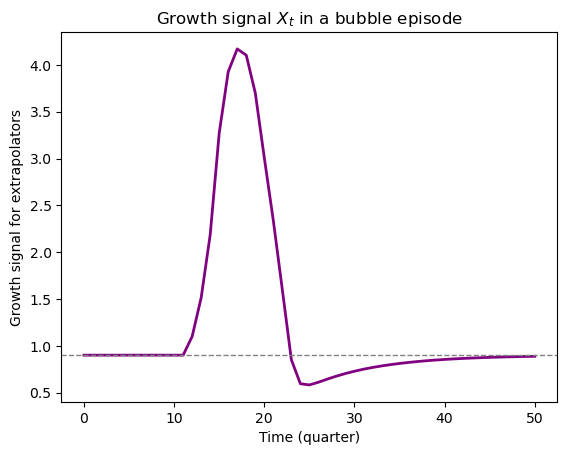

In [164]:
#growth signal
plt.plot(t, x_list, color = 'purple', linewidth=2.0)
plt.axhline(y = 0.9, color = 'grey', linestyle = '--', linewidth=1.0)
plt.xlabel("Time (quarter)")
plt.ylabel("Growth signal for extrapolators")
plt.title('Growth signal $X_t$ in a bubble episode')
plt.show()

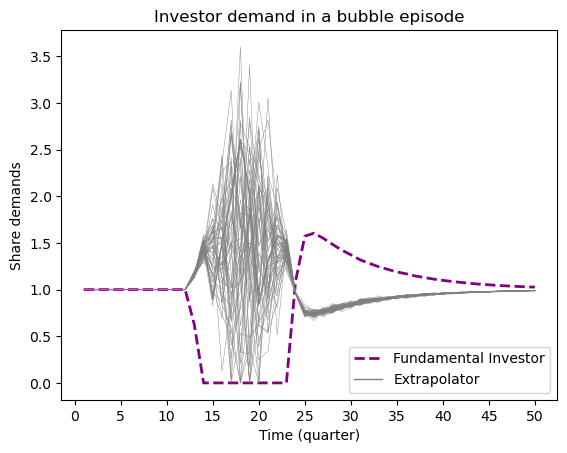

In [165]:
#Individual level investor demand
plt.plot(t[1:], np.array(d_list).T[0], label = "Fundamental Investor", color = 'purple', linestyle="--", linewidth=2.0)
plt.plot(t[1:], np.array(d_list).T[1], label = "Extrapolator", color = 'grey', linewidth=1.0)
plt.xticks([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50])
plt.legend(loc='lower right')

for _i in range(2, I):
    plt.plot(t[1:], np.array(d_list).T[_i], color = 'gray', linewidth=0.3)
    
plt.xlabel("Time (quarter)")
plt.ylabel("Share demands")
plt.title('Investor demand in a bubble episode')
plt.show()

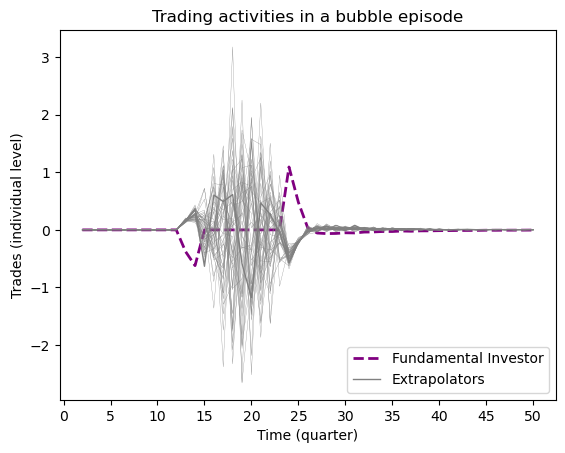

In [143]:
#Individual level trading activity
vol_0 = np.array(d_list).T[0] - shift(np.array(d_list).T[0], 1, cval=np.NaN)
plt.plot(t[1:], vol_0, label = "Fundamental Investor", color = 'purple', 
         linestyle="--", linewidth=2.0)
vol_1 = np.array(d_list).T[1] - shift(np.array(d_list).T[1], 1, cval=np.NaN)
plt.plot(t[1:], vol_1, label = "Extrapolators", color = 'gray', linewidth=1.0)

for _i in range(2, I):
    vol_i = np.array(d_list).T[_i] - shift(np.array(d_list).T[_i], 1, cval=np.NaN)
    plt.plot(t[1:], vol_i, color = 'gray', linewidth=0.2)

plt.xticks([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50])
plt.legend(loc='lower right')
plt.xlabel("Time (quarter)")
plt.ylabel("Trades (individual level)")
plt.title('Trading activities in a bubble episode')
plt.show()

In [135]:
vol_list = []
for _i in range(I+1):
    vol_i = np.absolute(np.array(d_list).T[_i] - shift(np.array(d_list).T[_i], 
                                                       1, cval=np.NaN))
    vol_list.append(list(vol_i))

In [147]:
ttl_vol = []
for trades in list(np.array(vol_list).T):
    ttl_vol.append(0.5*(np.dot(mu, trades)))

In [161]:
exp_vol = []
for trades in list(np.array(vol_list).T):
    exp_vol.append(0.5*(np.dot(mu, trades)) - np.dot(mu[0],trades[0]))

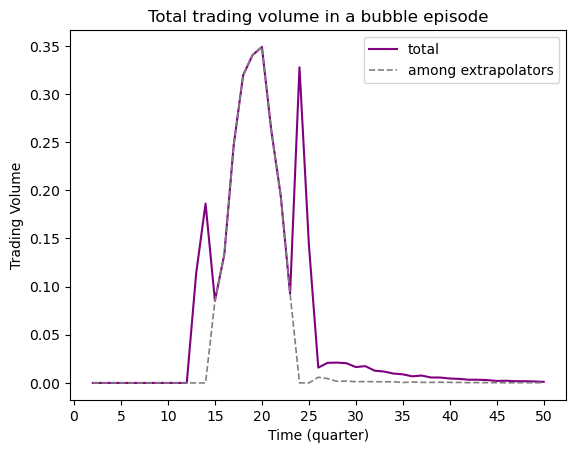

In [162]:
#Total trading volume
plt.plot(t[1:], ttl_vol, color = 'purple', label = 'total')
plt.plot(t[1:], exp_vol, color = 'grey', label = 'among extrapolators', 
         linestyle="--", linewidth=1.2)
plt.xticks([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50])
plt.legend(loc='upper right')
plt.xlabel("Time (quarter)")
plt.ylabel("Trading Volume")
plt.title('Total trading volume in a bubble episode')
plt.show()